# DAT 402 Project 1: Anaylzing Earthquakes from 2023-2024

### Imports

In [74]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from esda import Moran
from libpysal.weights import Queen
from esda.moran import Moran_Local
from splot.esda import plot_moran, lisa_cluster

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from statsmodels.tsa.holtwinters import ExponentialSmoothing

### Load earthquake data, natural earth data
Make geodataframe for earthquake data

In [92]:
eq = pd.read_csv('earthquakes.csv')
gdf = gpd.GeoDataFrame(
    eq, geometry=gpd.points_from_xy(eq['longitude'], eq['latitude']), crs="EPSG:4326"
)
natural_earth = gpd.read_file('natural_earth/ne_50m_admin_0_countries.shp')

Brief plot of earthquake data

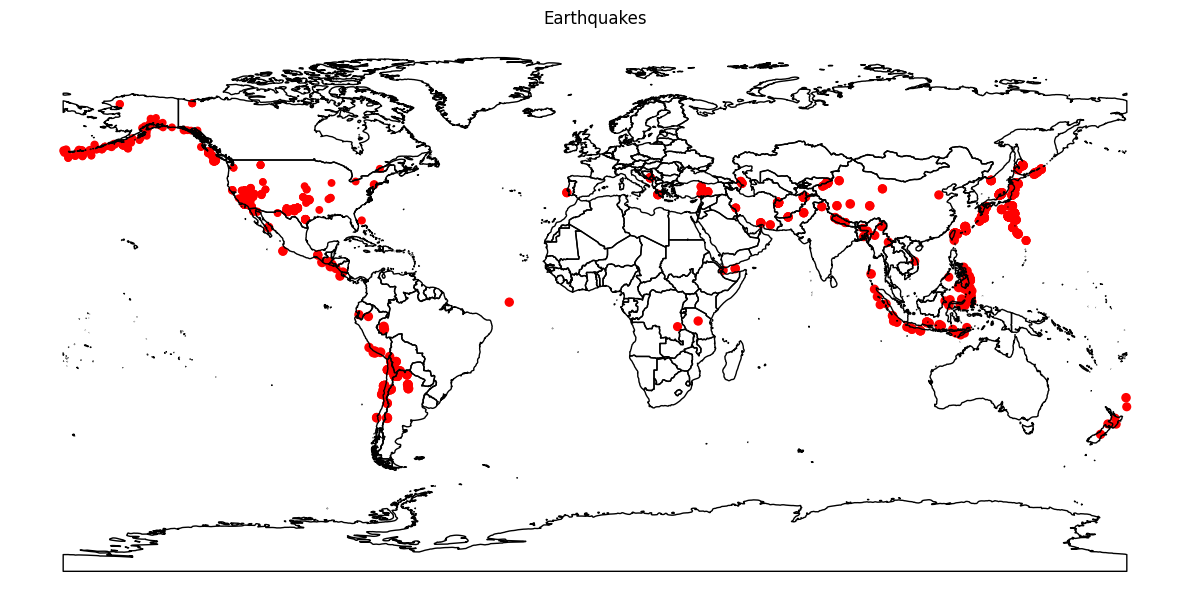

In [76]:
fig, ax = plt.subplots(figsize = (12,8))
gdf.plot(ax=ax,markersize=gdf['magnitude']*6,color='red')
natural_earth.plot(ax=ax,facecolor='none')
ax.set_title('Earthquakes')
ax.set_axis_off()
fig.tight_layout()

This is a simple plot of all the earthquakes in our data set. Some initial exploratory analysis shows that these events happen along tectonic plate fault lines. The area of the circles scale with the magnitude of the earthquakes. We can see what seems to be higher magnitude earthquakes in the South East Asia region by Japan and Indonesia, as well as near the Andes Mountaines in Chile, South America.

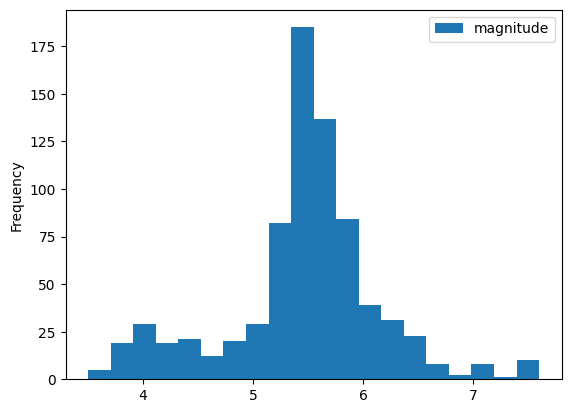

In [77]:
gdf_cleaned = gdf[['id','magnitude','felt','cdi','mmi','alert','sig','geometry']].dropna()
gdf_cleaned.plot.hist(column='magnitude',bins=20);

Here, we simply plotted the distrobution of magnitudes to see what kind of values were working with. There seems to be a mode around 5.5 and the data seems distrobuted normally.

### Scale and encode categorical and continuous data

In [78]:
scaler = StandardScaler()
#dummy variable
gdf_encoded = pd.get_dummies(gdf_cleaned, columns=['alert'], drop_first=True)

# Now 'alert' is one-hot encoded into multiple columns
predictors = gdf_encoded[['felt', 'cdi', 'mmi', 'sig'] + list(gdf_encoded.columns[gdf_encoded.columns.str.contains('alert')])]
predictors_scaled = scaler.fit_transform(predictors)

#grab predictors and split training and testing data
X = predictors_scaled
y = gdf_cleaned['magnitude']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Try Linear Regression

In [79]:

model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
print('Score:', model.score(X_test,y_test))


Score: 0.46715585920348734


Yikes. Our Linear Regression score is not that great, this suggest that there may be non-linear relationships among the features. Let's move on and try a different model.

### Try Random Forest Regressor

In [80]:

rf = RandomForestRegressor(random_state=42)

# Define a parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)


rf_model = RandomForestRegressor(**grid_search.best_params_)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
rf_model.fit(X_train, y_train)
rf_model.score(X_test,y_test)

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Cross-validation scores: [0.90687306 0.96552708 0.92765449 0.83286123 0.93764128]


0.9307596887367706

Our Random Forest model seemed to perform well in predicting magnitude, with an accuracy of .93. ALso, we are able to determine a few best parameters using GridSearchCV. Our cross valitdation scores are also high.

### Now try KNN

Best k: 5


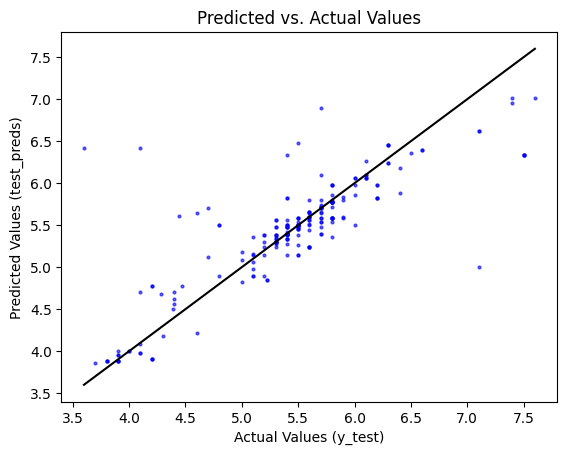

In [81]:
knn = KNeighborsRegressor()
param_grid = {'n_neighbors':list(range(1,101))}
grid_search = GridSearchCV(knn, param_grid, cv=10)
grid_search.fit(X_train,y_train)

mean_scores = grid_search.cv_results_['mean_test_score']
n_neighbors = list(range(1, 101))

k_best = list(grid_search.best_params_.values())[0]
print('Best k:', k_best)

knn = KNeighborsRegressor(n_neighbors=k_best)
model = knn.fit(X_train,y_train)
test_preds = model.predict(X_test)

# Create a scatter plot of actual vs. predicted values
plt.scatter(y_test, test_preds, color='blue', alpha=0.6,s=4)

# Plot a reference line for perfect predictions (y = x)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='-')

# Add labels and title
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (test_preds)')
plt.title('Predicted vs. Actual Values')
# Show the plot
plt.show()

Using GridSearchCV, we determine out k best to be 5. And, our predicted vs actual plot seems pretty well correlated.

### KNN but for proximity?

KNN model score: 0.9039246611131388


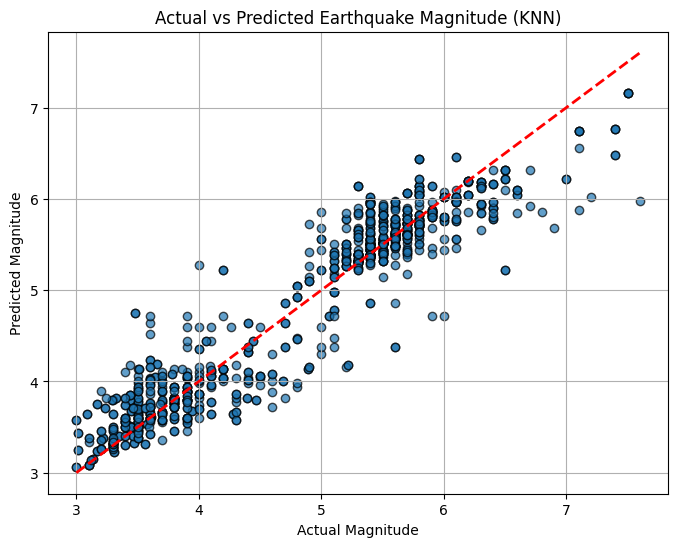

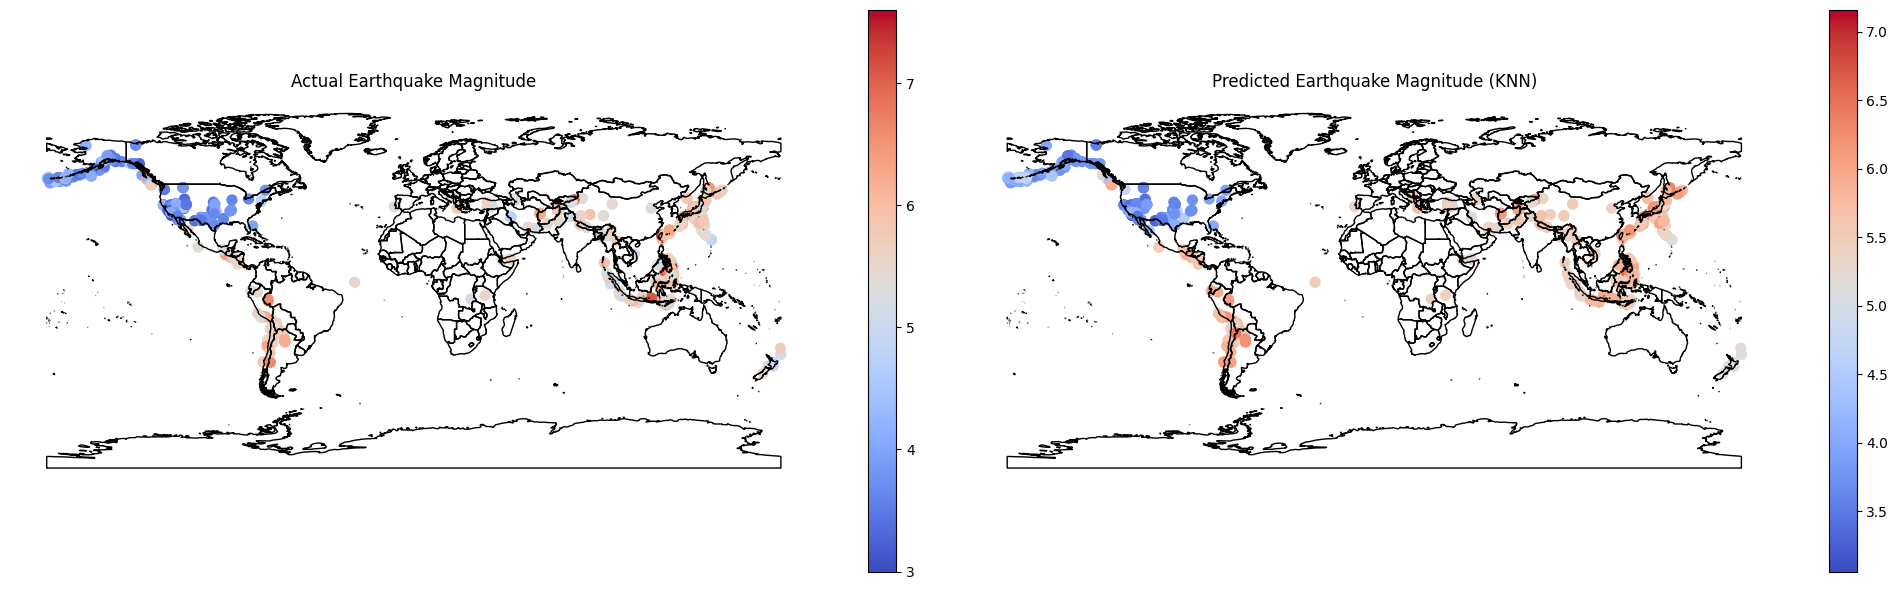

In [82]:
# Get coordinates from geometry (latitude, longitude)
X_coords = gdf['geometry'].apply(lambda geom: [geom.x, geom.y]).tolist()

# KNN model for predicting magnitude based on geospatial location
knn_model = KNeighborsRegressor(n_neighbors=k_best)
knn_model.fit(X_coords, gdf['magnitude'])

# Predict magnitude for test data or new points
y_pred = knn_model.predict(X_coords)
print('KNN model score:',knn_model.score(X_coords,gdf['magnitude']))
# Scatter plot of actual vs. predicted magnitudes
plt.figure(figsize=(8, 6))
plt.scatter(gdf['magnitude'], y_pred, alpha=0.7, edgecolors='k')
plt.plot([gdf['magnitude'].min(), gdf['magnitude'].max()],
         [gdf['magnitude'].min(), gdf['magnitude'].max()], 'r--', lw=2)  # Perfect prediction line
plt.xlabel('Actual Magnitude')
plt.ylabel('Predicted Magnitude')
plt.title('Actual vs Predicted Earthquake Magnitude (KNN)')
plt.grid(True)
plt.show()
# Create a column for the predicted magnitudes in your GeoDataFrame
gdf['predicted_magnitude'] = y_pred

# Plot actual vs predicted magnitudes on a map
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Plot actual magnitudes
gdf.plot(column='magnitude', ax=ax[0], legend=True, cmap='coolwarm', markersize=50)
natural_earth.plot(ax=ax[0],facecolor='none')
ax[0].set_title('Actual Earthquake Magnitude')
ax[0].set_axis_off()

# Plot predicted magnitudes
gdf.plot(column='predicted_magnitude', ax=ax[1], legend=True, cmap='coolwarm', markersize=50)
natural_earth.plot(ax=ax[1],facecolor='none')
ax[1].set_title('Predicted Earthquake Magnitude (KNN)')
ax[1].set_axis_off()

plt.tight_layout()
plt.show()

With a score of .904, our model is pretty accurate. Here, we have a plot of Actual Earthquake Magnitude and Predicted Earthquake Magnitude. As you can see, the predicted plot is representative of the actual events, with a few overestimates in some regions with some sparse outliers in magnitudes like the middle east.

### How about some unsupervised learning...
KMeans can be used to cluster features based on similarities like proximity. Great for visualizing spatial grouping.

c:\Users\AstroNoah\miniconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


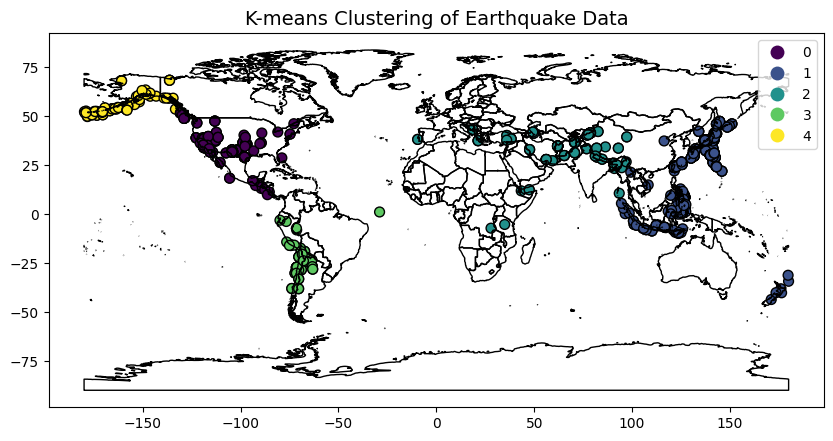

array([0, 2, 1, 3, 4])

In [84]:
kmeans = KMeans(n_clusters=5, random_state=42)
gdf['cluster'] = kmeans.fit_predict(X_coords)
# Step 3: Plot the clusters on a map
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the GeoDataFrame and color the points based on the assigned clusters
gdf.plot(column='cluster', categorical=True, legend=True, 
         cmap='viridis', markersize=50, ax=ax, edgecolor='black')
natural_earth.plot(ax=ax,facecolor='none')
# Add a title
ax.set_title('K-means Clustering of Earthquake Data', fontsize=14)

plt.show()

Here we can see that the Kmeans did a pretty good job of clustering the data into regions that make sense from a politcal map standpoint. We will use these region groups generated by Kmeans later on when we try and predict the next earthequake events.

Moran I Plot??

Moran's I: 0.7949840180891632, p-value: 0.001


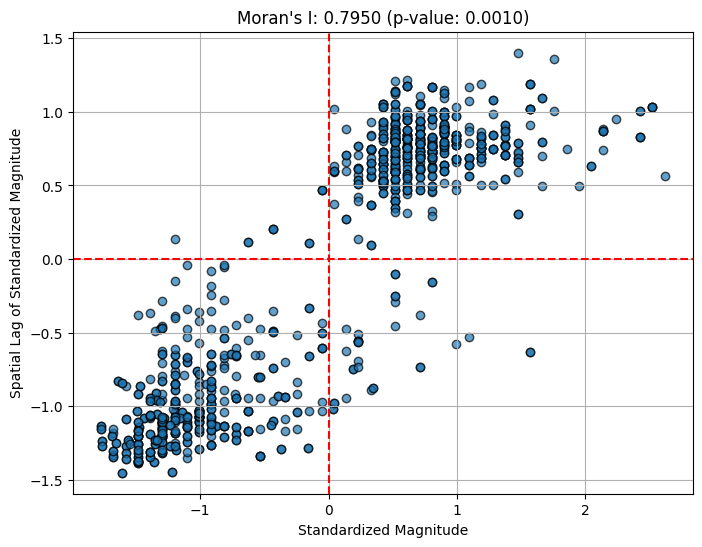

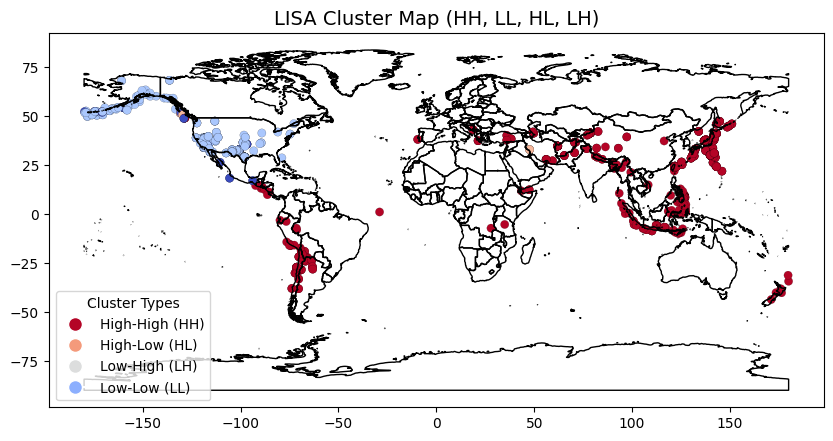

In [19]:

# Assuming 'gdf' is your GeoDataFrame with geometry in CRS 4236
# Compute spatial weights using Queen contiguity or distance-based methods
weights = Queen.from_dataframe(gdf,use_index=True)

# Calculate Moran's I for earthquake magnitude
moran = Moran(gdf['magnitude'], weights)
print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")
# Moran's I Scatter Plot
# Standardized values (z-scores) for magnitude
z = (gdf['magnitude'] - gdf['magnitude'].mean()) / gdf['magnitude'].std()

# Spatial lag of the z-scores
w_z = weights.sparse * z

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(z, w_z, edgecolors='k', alpha=0.7)
plt.axhline(0, color='r', linestyle='--')
plt.axvline(0, color='r', linestyle='--')
plt.xlabel('Standardized Magnitude')
plt.ylabel('Spatial Lag of Standardized Magnitude')
plt.title(f"Moran's I: {moran.I:.4f} (p-value: {moran.p_sim:.4f})")
plt.grid(True)
plt.show()


#Create a LISA cluster map
local_moran = Moran_Local(gdf['magnitude'], weights)

# Add cluster labels to the GeoDataFrame based on Moran's I
gdf['cluster'] = local_moran.q

cluster_labels = {
    1: 'HH',  # High-High
    2: 'HL',  # High
    3: 'LH',  # Low-Low
    4: 'LL'   # High-Low
}
gdf['cluster_label'] = gdf['cluster'].map(cluster_labels)

# Step 5: Plot the LISA cluster map with descriptive legend
fig, ax = plt.subplots(figsize=(10, 8))

# Define a color mapping for the clusters (HH, LL, HL, LH)
gdf.assign(
    cl=gdf['cluster_label']
).plot(column='cl', categorical=True, 
       cmap='coolwarm_r', linewidth=0.1, ax=ax, edgecolor='black', legend=True)
natural_earth.plot(ax=ax,facecolor='none')
# Add a title
ax.set_title('LISA Cluster Map (HH, LL, HL, LH)', fontsize=14)

# Create custom legend
# Handle the color mapping
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.coolwarm_r(i/4), markersize=10) 
           for i in range(4)]
labels = ['High-High (HH)', 'High-Low (HL)', 'Low-High (LH)', 'Low-Low (LL)']
ax.legend(handles, labels, title='Cluster Types', fontsize=10)

plt.show()

A Moran I plot is useful to analyze any spatial autocorrelation in earthquake magnitudes. Essentially, it looks to see if there is clustering based off of magnitude. In this case, there absolutely is. There is a high frequency of hits in the (+,+) and (-,-) parts of the plot, meaning that high magnitude earthquakes are surrounded by other high magnitude earthquakes, and low magnitude earthquakes are surrounded by other low magnitude earthquakes. A value of .7950 indicates that there is indeed spatial autocorrelation, and that magnitudes tend to cluster together geographically. The LISA cluster map shows the HH and LL autocorrelation geospatially.

# Neural Net Custom Regressor to Predict Magnitude

Create a FileDataset class to extract features and targets.

In [20]:
class FileDataset(Dataset):
    
    def __init__(self, df, feature_cols, target_cols, mean = None, sd = None):
        
        self.data = df
        
        self.features = self.data[feature_cols]
        self.targets = self.data[target_cols]
        
        self.cont_col = []
        self.cat_col = []
        
        for col in feature_cols:
            unique = self.features[col].unique()
            
            if set(unique).issubset({0.0, 1.0}):
                self.cat_col.append(col)
                
            else:
                self.cont_col.append(col)
        
        if mean is None:
            self.cont_mean = torch.tensor(self.features[self.cont_col].mean().values, dtype = torch.float32)
            
        else:
            self.cont_mean = torch.tensor(mean, dtype = torch.float32)
            
        if sd is None:
            self.cont_sd = torch.tensor(self.features[self.cont_col].std().values, dtype = torch.float32)
            
        else:
            self.cont_sd = torch.tensor(sd, dtype = torch.float32)
            
        self.cat_mean = torch.zeros(len(self.cat_col), dtype = torch.float32)
        self.cat_sd = torch.ones(len(self.cat_col), dtype = torch.float32)
        
    def __getitem__(self, index):
        
        cont_feature = self.features.iloc[index][self.cont_col].values.astype('float32')
        cat_feature = self.features.iloc[index][self.cat_col].values.astype('float32')
        target = self.targets.iloc[index].values.astype('float32')
        
        cont_tensor = (torch.tensor(cont_feature) - self.cont_mean) / self.cont_sd
        cat_tensor = torch.tensor(cat_feature)
        
        features = torch.cat((cont_tensor, cat_tensor), dim = 0)
        targets = torch.tensor(target)
        
        return features, targets
        
    def __len__(self):
        
        return len(self.data)

In [21]:
feature_cols = ['felt', 'cdi', 'mmi', 'sig', 'alert_orange', 'alert_red', 'alert_yellow']
target_cols = ['magnitude']

dataset = FileDataset(gdf_encoded, feature_cols, target_cols)
dataset


In [22]:
from torch.utils.data import random_split

np.random.seed(42)
torch.manual_seed(42)

## train-test
test_size = int(0.2 * len(dataset))
train_val_size = len(dataset) - test_size

train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size])

## train-val
val_size = int(0.1 * train_val_size)
train_size = train_val_size - val_size

train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

In [23]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True)
valid_loader = DataLoader(dataset = val_dataset, batch_size = 32, shuffle = False)
test_loader = DataLoader(dataset = test_dataset, batch_size = 32, shuffle = False)

 Make our custom model.

In [24]:
class CustomRegressor(nn.Module):
    def __init__(self, in_dim = 7, out_dim = 1):
        super(CustomRegressor, self).__init__()

        # hidden linear layers
        self.layer1 = nn.Linear(in_dim, 128, bias = True)
        self.layer2 = nn.Linear(128, 64, bias = True)
        self.layer3 = nn.Linear(64, 32, bias = True)

        # output layer
        self.out_layer = nn.Linear(32, 1, bias = True)

        # ReLU activation function
        self.relu = nn.ReLU()

    # how the model will run
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)

        x = self.layer2(x)
        x = self.relu(x)

        x = self.layer3(x)
        x = self.relu(x)

        x = self.out_layer(x)

        return x 

In [25]:
def train_loop_minibatch(data_loader, model, optimizer, loss_function):
    
    #Make sure we're in train mode
    model.train()
    
    total_loss = 0
    
    #Iterate through the mini-batches:
    for batch in data_loader:
        #Unpack to X and y
        X, y = batch
                
        #Get our prediction:
        pred = model(X)
        
        #And Loss:
        loss = loss_function(pred, y)

        #And now we do the backpropagation step:
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #Track the total loss:
        total_loss += loss.item()
    
    #Return the average total loss after this training step:
    return total_loss / len(data_loader)

In [26]:
epochs = 20
model = CustomRegressor()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
loss_function = nn.MSELoss()

Let's train our model and compare our train loss vs. validation loss.

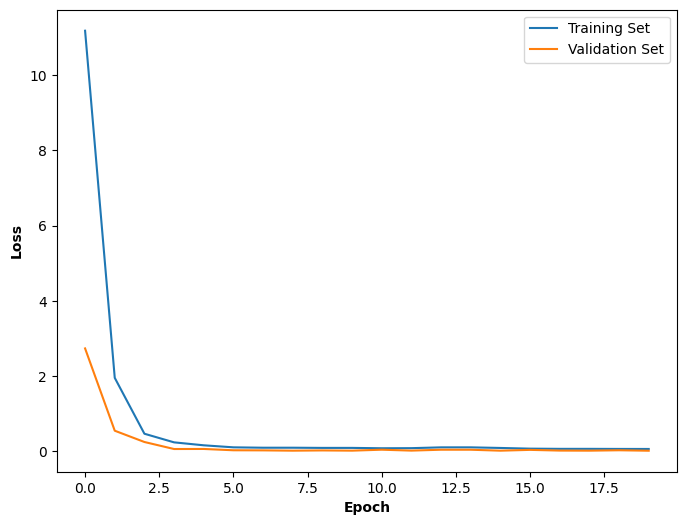

In [27]:
train_loss_list = []
valid_loss_list = []

for epoch in range(epochs):
    
    l = train_loop_minibatch(train_loader, model, optimizer, loss_function)
    train_loss_list.append(l)
    
    X, y = next(iter(valid_loader))
    with torch.no_grad():
        pred = model(X)
        
    valid_loss = loss_function(pred, y).item()
    valid_loss_list.append(valid_loss)

fig, ax1 = plt.subplots(1, 1, figsize = (8, 6))

ax1.plot(range(epochs), train_loss_list, label = 'Training Set')
ax1.plot(range(epochs), valid_loss_list, label = 'Validation Set')
ax1.set_xlabel('Epoch', weight = 'bold')
ax1.set_ylabel('Loss', weight = 'bold')
ax1.legend();

Now let's make predictions based off our training data and score our model on our testing dataset.

In [28]:
from sklearn.metrics import r2_score

def train_test_pred(data_loader, model):
    
    model.eval()
    
    preds = []
    target = []
    
    with torch.no_grad():  # No need to track gradients for evaluation
        for features, targets in data_loader:
            pred = model(features)  # Generate predictions
            preds.append(pred)
            target.append(targets)
            
    preds = torch.cat(preds, dim = 0).detach().numpy()
    target = torch.cat(target, dim = 0).detach().numpy()
    
    r2 = r2_score(target, preds)
    
    return preds, target, r2

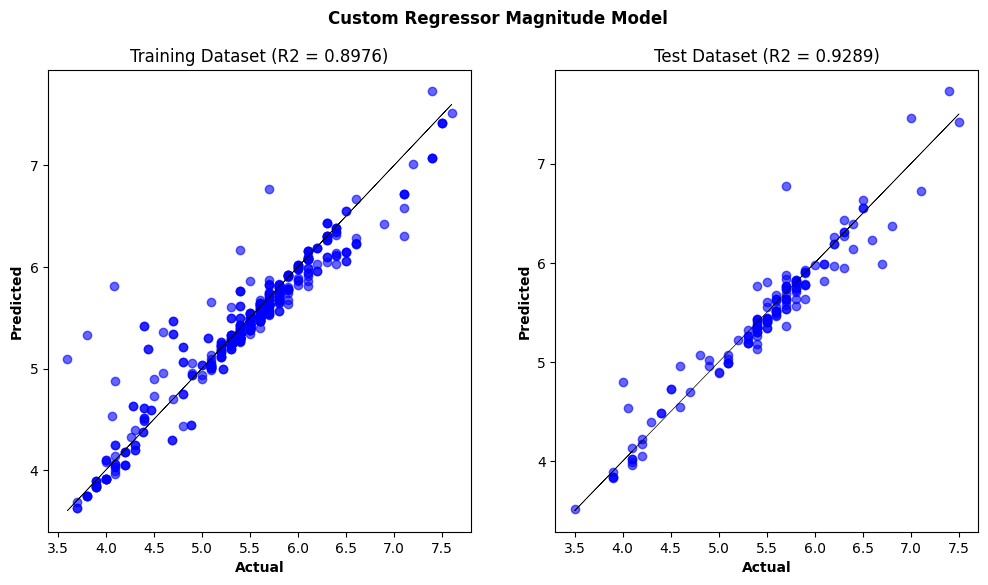

In [29]:
train_pred, train_actual, r2_train = train_test_pred(train_loader, model)
test_pred, test_actual, r2_test = train_test_pred(test_loader, model)

fig, ax1 = plt.subplots(1, 2, figsize = (12, 6))

ax1[0].scatter(train_actual, train_pred, alpha = 0.6, color = 'blue')
ax1[0].plot(train_actual, train_actual, lw = 0.5, color = 'black')
ax1[0].set_title(f'Training Dataset (R2 = {r2_train:.4f})')
ax1[0].set_xlabel('Actual', weight = 'bold')
ax1[0].set_ylabel('Predicted', weight = 'bold')

ax1[1].scatter(test_actual, test_pred, alpha = 0.6, color = 'blue')
ax1[1].plot(test_actual, test_actual, lw = 0.5, color = 'black')
ax1[1].set_title(f'Test Dataset (R2 = {r2_test:.4f})')
ax1[1].set_xlabel('Actual', weight = 'bold')
ax1[1].set_ylabel('Predicted', weight = 'bold')
plt.suptitle('Custom Regressor Magnitude Model', weight = 'bold');

### Can we predict when earthquakes may happen?
We encounter some problems when it comes to trying to predict models, specifically we only track the years 2023 and 2024 earthquakes, and that amount of data is not nearly enough to develop an accurate model. Instead, we will use the the clustering that Kmeans gave us to look at the average interval between events greater than 1 standard deviation away from the mean. We denote these as significant or more dangerous earthquakes for that region.

In [85]:
#Repeat Kmeans
kmeans = KMeans(n_clusters=5, random_state=42)
gdf['cluster'] = kmeans.fit_predict(X_coords)

c:\Users\AstroNoah\miniconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Next significant earthquake prediction for North and Central America: 2024-09-25
Threshold for significance: 4.59 (Magnitude)
Next significant earthquake prediction for Africa, Europe, Central Asia: 2024-02-13
Threshold for significance: 5.92 (Magnitude)
Next significant earthquake prediction for South East Asia: 2024-08-25
Threshold for significance: 6.14 (Magnitude)
Next significant earthquake prediction for South America: 2024-09-30
Threshold for significance: 6.32 (Magnitude)
Next significant earthquake prediction for Alaska: 2024-09-20
Threshold for significance: 4.61 (Magnitude)


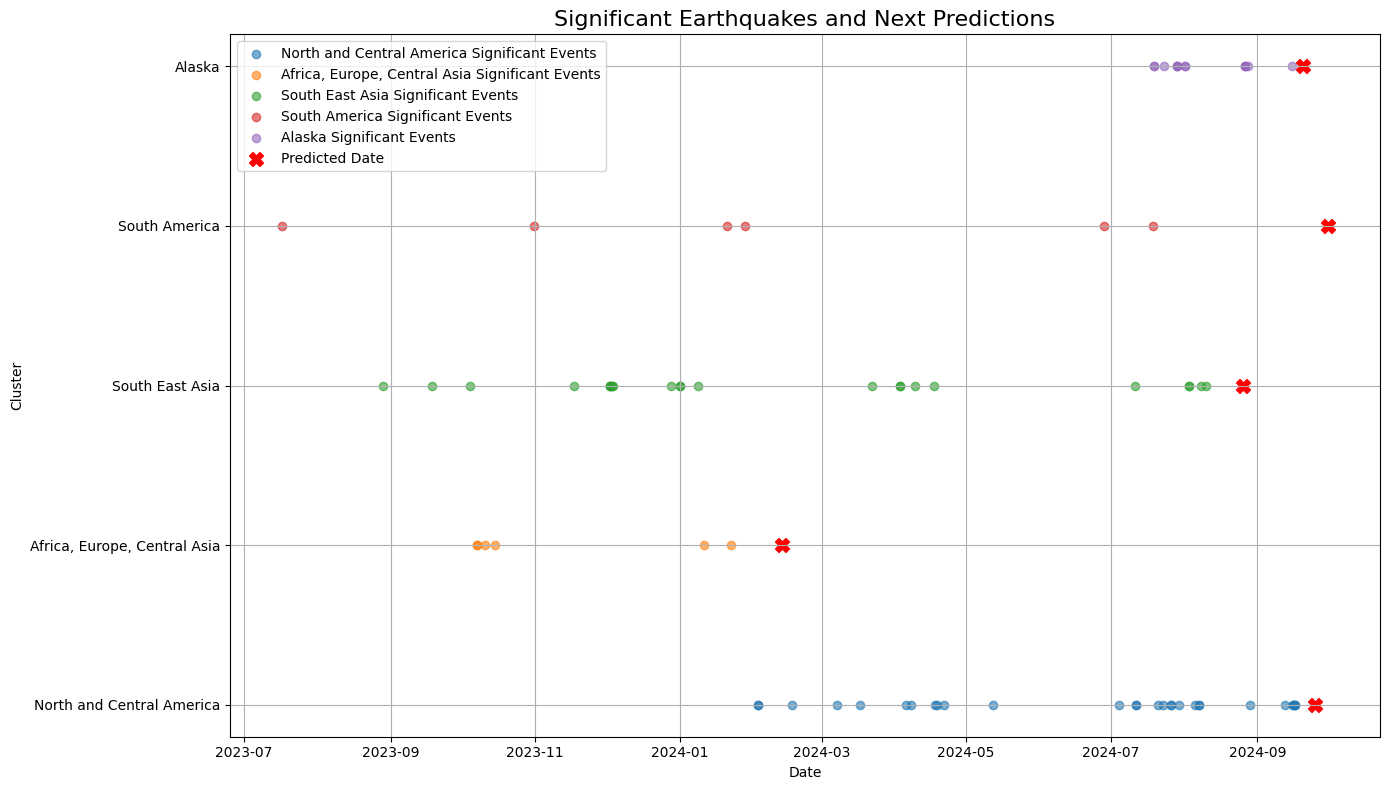

In [91]:
# Check for duplicates based on 'date' and 'magnitude'
duplicates = gdf[gdf.duplicated(subset=['date', 'magnitude'], keep=False)]

# Optionally remove duplicates
gdf = gdf.drop_duplicates(subset=['date', 'magnitude'], keep='first')
gdf['date'] = pd.to_datetime(gdf['date'])

# Ensure the 'date' column is in datetime format
gdf['date'] = pd.to_datetime(gdf['date'])

# Define a mapping for cluster names
cluster_names = {
    4: "Alaska",
    0: "North and Central America",
    3: "South America",
    2: "Africa, Europe, Central Asia",
    1: "South East Asia"
}

def predict_next_event_average(cluster_data):
    # Calculate the mean and standard deviation of the magnitudes
    mean_magnitude = cluster_data['magnitude'].mean()
    std_dev = cluster_data['magnitude'].std()

    # Set the threshold to 1 standard deviation above the mean
    threshold = mean_magnitude + std_dev
    significant_eqs = cluster_data[cluster_data['magnitude'] > threshold]

    # Check if we have enough data for forecasting
    if len(significant_eqs) < 2:
        print("Not enough significant earthquakes found in this cluster.")
        return None, None, threshold

    # Sort significant earthquakes by date
    significant_eqs = significant_eqs.sort_values('date')

    # Calculate time intervals between consecutive significant earthquakes
    intervals = significant_eqs['date'].diff().dropna()

    # Calculate the average interval
    average_interval = intervals.mean()

    # Print historical dates used for calculations
    #print(f"{cluster_names[cluster_data['cluster'].iloc[0]]} - Historical Significant Earthquake Dates:")
    #print(significant_eqs['date'].tolist())

    # Predict the next event date by adding the average interval to the last event date
    last_event_date = significant_eqs['date'].max()
    next_event_date = last_event_date + average_interval

    return next_event_date, significant_eqs, threshold

# Apply the prediction function to each cluster and store predictions
next_events = {}
historical_significant_eqs = {}
thresholds = {}

for cluster_id in gdf['cluster'].unique():
    cluster_data = gdf.loc[gdf['cluster'] == cluster_id]
    next_event_date, significant_eqs, threshold = predict_next_event_average(cluster_data)
    if next_event_date is not None:
        next_events[cluster_id] = next_event_date
        historical_significant_eqs[cluster_id] = significant_eqs
        thresholds[cluster_id] = threshold  # Store the threshold

# Display the next predicted events for each cluster with new names
for cluster_id, next_event in next_events.items():
    print(f"Next significant earthquake prediction for {cluster_names[cluster_id]}: {next_event.date()}")
    print(f"Threshold for significance: {thresholds[cluster_id]:.2f} (Magnitude)")

# Plot historical significant earthquakes and predictions
fig, ax = plt.subplots(figsize=(14, 8))  # Increased figure size

# Plot each cluster's historical significant earthquakes
for cluster_id, eqs in historical_significant_eqs.items():
    ax.scatter(eqs['date'], [cluster_names[cluster_id]] * len(eqs), label=f'{cluster_names[cluster_id]} Significant Events', alpha=0.6)

# Plot the predicted dates with a single legend entry
for cluster_id, next_event in next_events.items():
    ax.scatter(next_event, cluster_names[cluster_id], color='red', marker='X', s=100)

# Add a single legend entry for predicted dates
ax.scatter([], [], color='red', marker='X', s=100, label='Predicted Date')

# Annotate the thresholds on the plot
for cluster_id, threshold in thresholds.items():
    ax.annotate(f'Min Threshold: {threshold:.2f}', 
                xy=(ax.get_xlim()[1] * 0.9, cluster_names[cluster_id]), 
                textcoords='offset points', 
                xytext=(-10, 5), 
                fontsize=10, 
                color='black')

# Formatting the plot
ax.set_title('Significant Earthquakes and Next Predictions', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('Cluster')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

There are some interesting observations here. First, Both North America and Alaska have a significant portion of time with no significant events occuring, and a similar effect with the Africa,Europe, and Central Asia region for the latter have of the obervation window. South East Asia seems to have more consistent earthquakes with the second highest magnitude threshold at 6.14, while South America has the highest magnitude threshold with more sparse events occuring. This could help response agencies understand patterns in a regions tectonic plate movements. The response frequncy and severety should differe between South America and South East Asia due to the differences in magnitude and frequency of the earthquakes. With more time series data, it may be possible to creat forecasting models such as ARIMA for non seasonal trends like earthquakes.